**BWA and minimap2 resulted in slightly different variant calling validation results, running on the ICGC MB dataset (100x tumor vs 100x normal). Trying to analyse the origin of that discrepancy.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys

**Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls. Earlier we evaluated calls against the truth set, so here we have 3 sets of VCFs for each caller: `0000.vcf` (false positives), `0001.vcf` (false negatives), `0002.vcf` (true positives).**

In [2]:
import pandas as pd
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from os.path import join
from collections import Counter

callers = ['strelka2']  #, 'vardict', 'mutect2']

vcfs = {}
for c in callers:
    bwa_dir = f'giab/eval/UtahMormon-1-bwa-{c}-annotated_bcftools_isec'
    mm2_dir = f'giab/eval/UtahMormon-1-mm2-{c}-annotated_bcftools_isec'
    vcfs[c] = dict(
        bwa=dict(
            fp=join(bwa_dir, '0000.vcf'),
            fn=join(bwa_dir, '0001.vcf'),
            tp=join(bwa_dir, '0002.vcf'),
        ),
        mm2=dict(
            fp=join(mm2_dir, '0000.vcf'),
            fn=join(mm2_dir, '0001.vcf'),
            tp=join(mm2_dir, '0002.vcf'),
        ),
    )
validate_types = ['fp', 'tp', 'fn']

main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def extract_mq(rec_, caller_):
    if rec_ is None:
        return None
    if caller_ == 'vardict':
        try:
            return rec_.format('MQ')[main_sample_index][0]
        except:
            print(rec_)
            raise
    if caller_ == 'strelka2':
        try:
            return rec_.INFO['MQ']
        except:
            print(rec_)
            raise
    if caller_ == 'mutect2':
        try:
            return rec_.format('MMQ')[main_sample_index][0] if rec_ else None
        except:
            print(rec_)
    
def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]
    
rows = []
for caller in callers:
    print(f'Parsing VCFs for {caller}')
    recs_by_loc = defaultdict(lambda: [(None, 'tn'), (None, 'tn')])
    for typ, vcf in vcfs[caller]['bwa'].items():
        for rec in VCF(vcf):            
            if rec.FILTER:
                continue
            k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
            recs_by_loc[k][0] = (rec, typ)            
    for typ, vcf in vcfs[caller]['mm2'].items():
        for rec in VCF(vcf):
            if rec.FILTER:
                continue
            k = (rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
            recs_by_loc[k][1] = (rec, typ)
    
    print(f'Analysing data for {caller}, building dataframe')
    total = 0
    for (chrom, pos, ref, alt), [(bwa, bwa_t), (mm2, mm2_t)] in sorted(recs_by_loc.items(), key=lambda a: a[0]):    
        assert bwa_t and mm2_t
        total += 1
        if total % 100_000 == 0:
            print(f'Processed {total} records')
        
        x = next((p for c, p in chrom_positions if str(c) == str(chrom)), None)
        if x is None:
            continue
        x += pos
        
        fields = dict(gene='')
        
        for aln_name, rec, aln_type in (['bwa', bwa, bwa_t], ['mm2', mm2, mm2_t]):
            if aln_type in ('fp', 'tp'):
                for tag in ['AF', 'DP', 'MQ']:
                    for ph in ['TUMOR', 'NORMAL']:
                        v = rec.INFO.get(f'{ph}_{tag}')
                        if v:
                            fields[f'{aln_name}_{ph}_{tag}'] = v
                        
                fields[f'{aln_name}_QUAL'] = rec.QUAL
            
                if caller == 'vardict':
                    fields[f'{aln_name}_NM'] = rec.format('NM')[main_sample_index][0]
                
                ann = rec.INFO.get('ANN')
                if isinstance(ann, str):  # skip decomposed fields with lost ANN
                    fields['gene'] = ann.split('|')[3]
                    
                if caller == 'strelka2':
                    fields[f'{aln_name}_SomaticEVS'] = rec.INFO.get('SomaticEVS')
                    fields[f'{aln_name}_ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')

        if bwa is not None and mm2 is not None:
            assert bwa.is_snp == mm2.is_snp, (bwa, bwa_t, mm2, mm2_t)

        positive_rec = bwa if (bwa_t in ('tp', 'fp')) else mm2
        
        tricky_anno = positive_rec.INFO.get('TRICKY', '').split(',')
        tricky_anno = tuple([a for a in tricky_anno if a and a not in 
             ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']])
        
        row = {
            'caller': caller,
            'pos': pos,
            'label': f'{chrom}:{pos}-{ref}>{alt}', 
            'called_with_bwa': bwa_t in ('tp', 'fp'),
            'called_with_mm2': mm2_t in ('tp', 'fp'),
            'chrom': chrom,
            'x': x,
            'passed': not positive_rec.FILTER,
            'is_snp': positive_rec.is_snp,
            'tricky_anno': tricky_anno,
            'bwa_t': bwa_t,
            'mm2_t': mm2_t,
        }
        row.update(fields)
        rows.append(row)
    
    print(f'Done parsing {caller}, total variants: ', str(total))
    print()

df = pd.DataFrame(rows)

Parsing VCFs for strelka2
Analysing data for strelka2, building dataframe
Processed 100000 records
Processed 200000 records
Processed 300000 records
Processed 400000 records
Processed 500000 records
Processed 600000 records
Processed 700000 records
Processed 800000 records
Processed 900000 records
Processed 1000000 records
Processed 1100000 records
Processed 1200000 records
Processed 1300000 records
Processed 1400000 records
Processed 1500000 records
Processed 1600000 records
Processed 1700000 records
Processed 1800000 records
Processed 1900000 records
Processed 2000000 records
Processed 2100000 records
Processed 2200000 records
Processed 2300000 records
Processed 2400000 records
Processed 2500000 records
Processed 2600000 records
Processed 2700000 records
Processed 2800000 records
Processed 2900000 records
Processed 3000000 records
Processed 3100000 records
Processed 3200000 records
Processed 3300000 records
Processed 3400000 records
Processed 3500000 records
Processed 3600000 records

**Counting statistics on per-chromosome basis: unique to BWA vs. unqiue to minimap2 vs. common calls. Drawing summary Venn diagrams for each caller.**

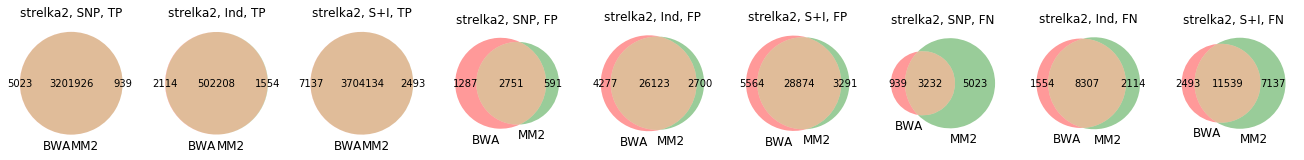

In [5]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib import gridspec

def _get_category(x):
    return {
        ('tp', 'fn'): 'unique_tp_bwa',
        ('fn', 'tp'): 'unique_tp_mm2',
        ('fp', 'tn'): 'unique_fp_bwa',
        ('tn', 'fp'): 'unique_fp_mm2',  
        ('tp', 'tp'): 'common_tp',
        ('fp', 'fp'): 'common_fp',
        ('fn', 'fn'): 'common_fn',
    }[(x['bwa_t'], x['mm2_t'])]
    
df['category'] = df.apply(_get_category, axis=1)

#print(df[['caller', 'is_snp', 'bwa_t', 'mm2_t', 'category', 'chrom']])

stats_by_cat_by_chrom = defaultdict(Counter)
for (caller, is_snp, category, chrom), g in df.groupby(['caller', 'is_snp', 'category', 'chrom']):
    stats_by_cat_by_chrom[(caller, is_snp, category)][chrom] += len(g)

# Plotting Venn diagrams   
for caller_i, caller in enumerate(callers):
#     print(caller)
    
    fig = plt.figure(figsize=(23, 23))
    plt.title(f'BWA vs minimap2 calls for {caller}')
    grid = gridspec.GridSpec(1, 9, width_ratios=[1] * 9)
    """ strelka:  snp  ind  all  
                  tp      
                  fp     
                  tp+fp          """    
    all_tp_subsets = Counter()
    all_fp_subsets = Counter()
    all_fn_subsets = Counter()
    all_subsets = Counter()
        
    for is_snp_i, is_snp in enumerate([True, False]):
        lbl = 'SNP' if is_snp else 'Ind'
        
        tp_subsets = Counter({
            '10': sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_tp_bwa')].values()),
            '01': sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_tp_mm2')].values()),
            '11': sum(stats_by_cat_by_chrom[(caller, is_snp, 'common_tp')].values()),
        })
        fp_subsets = Counter({
            '10': sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_fp_bwa')].values()),
            '01': sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_fp_mm2')].values()),
            '11': sum(stats_by_cat_by_chrom[(caller, is_snp, 'common_fp')].values()),
        })
        fn_subsets = Counter({
            '10': sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_tp_mm2')].values()),
            '01': sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_tp_bwa')].values()),
            '11': sum(stats_by_cat_by_chrom[(caller, is_snp, 'common_fn')].values()),
        })
#         print('    tp bwa: ', sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_tp_bwa')].values()))
#         print('    fp bwa: ', sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_fp_bwa')].values()))
#         print('    fp mm2: ', sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_tp_mm2')].values()))
#         print('    fp mm2: ', sum(stats_by_cat_by_chrom[(caller, is_snp, 'unique_fp_mm2')].values()))
#         print('    tp common: ', sum(stats_by_cat_by_chrom[(caller, is_snp, 'common_tp')].values()))
#         print('    fp common: ', sum(stats_by_cat_by_chrom[(caller, is_snp, 'common_fp')].values()))
        subsets = tp_subsets + fp_subsets
        
        ax = plt.subplot(grid[0 + is_snp_i])
        venn2(tp_subsets, set_labels=('BWA', 'MM2'), ax=ax)
        ax.set_title(f'{caller}, {lbl}, TP')

        ax = plt.subplot(grid[3 + is_snp_i])
        venn2(fp_subsets, set_labels=('BWA', 'MM2'), ax=ax)
        ax.set_title(f'{caller}, {lbl}, FP')

        ax = plt.subplot(grid[6 + is_snp_i])
        venn2(fn_subsets, set_labels=('BWA', 'MM2'), ax=ax)
        ax.set_title(f'{caller}, {lbl}, FN')
                
        all_tp_subsets += tp_subsets
        all_fp_subsets += fp_subsets
        all_subsets += subsets 
        all_fn_subsets += fn_subsets
    
    ax = plt.subplot(grid[0 + 2])
    venn2(all_tp_subsets, set_labels=('BWA', 'MM2'), ax=ax)
    ax.set_title(f'{caller}, S+I, TP')

    ax = plt.subplot(grid[3 + 2])
    venn2(all_fp_subsets, set_labels=('BWA', 'MM2'), ax=ax)
    ax.set_title(f'{caller}, S+I, FP')

    ax = plt.subplot(grid[6 + 2])
    venn2(all_fn_subsets, set_labels=('BWA', 'MM2'), ax=ax)
    ax.set_title(f'{caller}, S+I, FN')

In [ ]:
# Defining plotting functions

## Prepare colors for variant vs coordinate plots
from matplotlib.ticker import LinearLocator
from matplotlib import rc, font_manager

def set_color(d):
    if d['validate'] == 'fn':
        color = 'green'
        zorder = 2
    
    if not d['called_with_bwa']:
        assert d['called_with_mm2']
        color = 'lightblue'
        zorder = 0
        if d['validate'] == 'tp':
            color = 'blue'
            zorder = 1
            
    elif not d['called_with_mm2']:
        assert d['called_with_bwa']
        color = 'pink'
        zorder = 0
        if d['validate'] == 'tp':
            color = 'red'
            zorder = 1
            
    else:
        assert d['called_with_bwa']
        assert d['called_with_mm2']
        color = 'gray'
        zorder = 1
        if d['validate'] == 'tp':
            color = 'black'
            zorder = -1
    return color, zorder

def get_colors(category):
    """ Return color of BWA dot, color of minimap2 dot, and color of line connecting dots
    """
    
    if category == ('tp', 'tp'):
        return 'purple', 'purple', 'purple'

    elif category == ('tp', 'fn'):
        return 'blue', None, None
    
    elif category == ('fp', 'fp'):
        return 'violet', 'violet', 'violet'

    elif category == ('fp', 'tn'):
        return 'lightblue', None, None
        
    elif category == ('fn', 'tp'):
        return None, 'red', None
        
    elif category == ('fn', 'fn'):
        return 'green', None, None
        
    elif category == ('tn', 'fp'):
        return None, 'pink', None
    
    else:
        return None, None, None

# for caller in callers:
#     df_by_c[caller]['color']  = df_by_c[caller].apply(lambda row: set_color(row)[0], axis=1)
#     df_by_c[caller]['zorder'] = df_by_c[caller].apply(lambda row: set_color(row)[1], axis=1)
# print(f'Done colors')

## Plotting chromosome ticks
def draw_ticks(ax, chrom=None):
    chrom_poss = chrom_positions
    if chrom:
        chrom_poss = [(c, p) for c, p in chrom_positions if c in [str(chrom), int_to_chrom(chrom_to_int(chrom) + 1)]]

    ax.set_xlim([chrom_poss[0][1], chrom_poss[-1][1]])
    
    return chrom_poss

## Plotting data
def plot(caller, field, field_name=None, chrom=None, max_y=None):
    # Plotting MQ differrence by coordinate
    dfc = df[df['caller'] == caller]
    field_name = field_name or field.upper()

    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(111, label=f'{caller}_{field}', 
                         title=f'{field_name} for variant calls from BWA (blue) vs. minimap2 (red) alignments')
    chrom_poss = draw_ticks(ax, chrom)
    
    modify = modify_back = lambda v: v
    if max_y:
        modify = lambda v: max_y+( - max_y)/10 if v > max_y else v
        modify_back = lambda v: max_y+(v-max_y)*10 if v > max_y else v
    
    # Plotting dots
    for category, g in dfc.groupby(['bwa_t', 'mm2_t', 'tricky_anno']):
#        assert 'bwa' in g.field_by_aligner, len(g.field_by_aligner)
#        assert 'mm2' in g.field_by_aligner, g.field_by_aligner
        (bwa_validate, mm2_validate, tricky_anno) = category
        bwa_color, mm2_color, line_color = get_colors((bwa_validate, mm2_validate))
        try:
            bys = g[f'bwa_{field}'].map(modify)
        except:
            raise
        mys = g[f'mm2_{field}'].map(modify)
        marker = 'x' if tricky_anno else '.'
        if bwa_color:
            ax.scatter(g['x'], bys, marker=marker, color=bwa_color)
        if mm2_color:
            ax.scatter(g['x'], mys, marker=marker, color=mm2_color)
        if line_color:
            for index, row in g.iterrows():
                by = modify(row[f'bwa_{field}'])
                my = modify(row[f'mm2_{field}'])
                ax.plot([row['x'], row['x']], [by, my], color=line_color, linewidth=1)
    
    s = stats_by_cat_by_chrom
    def _make_lbl(c):
        cs = dict(
            c_snp_t = s[caller, True, "common_tp"][c],
            c_ind_t = s[caller, False, "common_tp"][c],
            c_snp_f = s[caller, True, "common_fp"][c],
            c_ind_f = s[caller, False, "common_fp"][c],
            b_snp_t = s[caller, True, "unique_tp_bwa"][c],
            b_ind_t = s[caller, False, "unique_tp_bwa"][c],
            b_snp_f = s[caller, True, "unique_fp_bwa"][c],
            b_ind_f = s[caller, False, "unique_fp_bwa"][c],
            m_snp_t = s[caller, True, "unique_tp_mm2"][c],
            m_ind_t = s[caller, False, "unique_tp_mm2"][c],
            m_snp_f = s[caller, True, "unique_fp_mm2"][c],
            m_ind_f = s[caller, False, "unique_fp_mm2"][c],
        )
        max_snp_len = max([len(str(v)) for k, v in cs.items() if 'snp' in k])
        max_ind_len = max([len(str(v)) for k, v in cs.items() if 'ind' in k])
            
        if c == '1':
            return '\n'.join([f'{c}', 
                              f'Common   T {cs["c_snp_t"]:{max_snp_len}}+{cs["c_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["c_snp_f"]:{max_snp_len}}+{cs["c_ind_f"]:{max_ind_len}}', 
                              f'BWA uniq T {cs["b_snp_t"]:{max_snp_len}}+{cs["b_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["b_snp_f"]:{max_snp_len}}+{cs["b_ind_f"]:{max_ind_len}}', 
                              f'MM2 uniq T {cs["m_snp_t"]:{max_snp_len}}+{cs["m_ind_t"]:{max_ind_len}} ',
                              f'         F {cs["m_snp_f"]:{max_snp_len}}+{cs["m_ind_f"]:{max_ind_len}}', 
                              ])
        else:
            return '\n'.join([f'{c}', 
                              f'{cs["c_snp_t"]:{max_snp_len}}+{cs["c_ind_t"]:{max_ind_len}} ',
                              f'{cs["c_snp_f"]:{max_snp_len}}+{cs["c_ind_f"]:{max_ind_len}}', 
                              f'{cs["b_snp_t"]:{max_snp_len}}+{cs["b_ind_t"]:{max_ind_len}} ',
                              f'{cs["b_snp_f"]:{max_snp_len}}+{cs["b_ind_f"]:{max_ind_len}}', 
                              f'{cs["m_snp_t"]:{max_snp_len}}+{cs["m_ind_t"]:{max_ind_len}} ',
                              f'{cs["m_snp_f"]:{max_snp_len}}+{cs["m_ind_f"]:{max_ind_len}}', 
                              ])
    
    plt.xticks([pos for c, pos in chrom_poss], 
               [_make_lbl(c) if c else '' for c, _ in chrom_poss],
              horizontalalignment='left',
              fontproperties=font_manager.FontProperties(family='monospace'))
    
    if max_y:
        ax.set_yticklabels([modify_back(l) for l in ax.get_yticks().tolist()])
        ax.plot([0, dfc['x'].max()], [max_y, max_y], color='black', linestyle='--', linewidth=1)

#         grouped = df.groupby('zorder')
#         for zorder, g in grouped:
#             ax.scatter(g['x'], g[f'bwa_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)
#             ax.scatter(g['x'], g[f'mm2_{field}'].map(modify), marker='.', color=g['color'], zorder=zorder)

    ax.set_xlim([chrom_poss[0][1]1, chrom_poss[-1][1]])
    plt.grid()
    
    return dfc, ax

#plot('strelka2', 'TUMOR_DP', max_y=300)
#plot('strelka2', 'NORMAL_DP', max_y=300)
pass

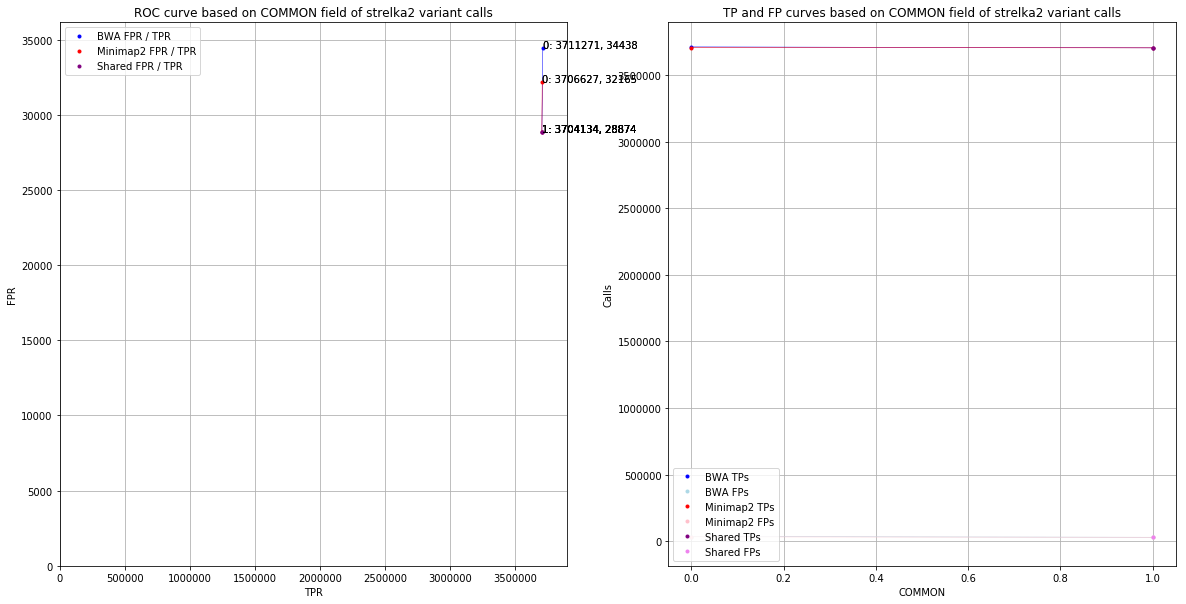

In [4]:
# Defining function for plotting ROC and TP/FP ratios curves

from matplotlib import gridspec
from matplotlib.transforms import blended_transform_factory

def plot_roc(caller, field, start, end, step=1, label_step=5, show_values=False):
    dfc = df[df['caller'] == caller]

    fig = plt.figure(figsize=(20, 10))
    grid = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    roc_ax = plt.subplot(grid[0], 
         label=f'ROC {caller} {field.upper()}', 
         title=f'ROC curve based on {field.upper()} field of {caller} variant calls')
    roc_ax.set_xlabel('TPR')
    roc_ax.set_ylabel('FPR')
    plt.grid()
    tp_fp_ax = plt.subplot(grid[1], 
         label=f'TP and FP {caller} {field.upper()}', 
         title=f'TP and FP curves based on {field.upper()} field of {caller} variant calls')  
    tp_fp_ax.set_xlabel(f'{field.upper()}')
    tp_fp_ax.set_ylabel('Calls')
    plt.grid()
    
    # Pre-calculation    
    max_tp = 0
    max_fp = 0
    tps_by_aln = defaultdict(list)
    fps_by_aln = defaultdict(list)
    for aln in ['bwa', 'mm2']:
        vals = np.arange(start, end + step, step)
        for val in vals:
            val_data = dfc[dfc[aln + '_' + field] >= val]
            
            tp = len(val_data[val_data[f'{aln}_t'] == 'tp'])
            fn = len(val_data[val_data[f'{aln}_t'] == 'fn'])
            fp = len(val_data[val_data[f'{aln}_t'] == 'fp'])
            
            tps_by_aln[aln].append(tp)
            fps_by_aln[aln].append(fp)
            #tprs.append(tp / (tp + fn))
            #fprs.append(fp / (fp + tn))
    
    max_tp = max(max(vs) for vs in tps_by_aln.values())
    max_fp = max(max(vs) for vs in fps_by_aln.values())
    
    com = []
    bwa = []
    mm2 = []
    
    for val, bwa_tp, bwa_fp, mm2_tp, mm2_fp in zip(
        vals, tps_by_aln['bwa'], fps_by_aln['bwa'], tps_by_aln['mm2'], fps_by_aln['mm2']):
        bwa.append([val, bwa_tp, bwa_fp])
        mm2.append([val, mm2_tp, mm2_fp])
        if bwa_tp == mm2_tp and bwa_fp == mm2_fp:
            com.append([val, bwa_tp, bwa_fp])

    # ROC curve plots
    roc_ax.plot([p[1] for p in bwa], [p[2] for p in bwa], '-', c='blue',   lw=0.5)
    roc_ax.plot([p[1] for p in bwa], [p[2] for p in bwa], '.', c='blue',   label=f'BWA FPR / TPR')
    roc_ax.plot([p[1] for p in mm2], [p[2] for p in mm2], '-', c='red',    lw=0.5)
    roc_ax.plot([p[1] for p in mm2], [p[2] for p in mm2], '.', c='red',    label=f'Minimap2 FPR / TPR')
    roc_ax.plot([p[1] for p in com], [p[2] for p in com], '-', c='purple', lw=0.5)
    roc_ax.plot([p[1] for p in com], [p[2] for p in com], '.', c='purple', label=f'Shared FPR / TPR')

    for aln in ['bwa', 'mm2']:
        for v, x, y in com + bwa + mm2:
            label = f'{v}'
            if show_values:
                label += f': {x}, {y}'
            if v % label_step == 0:
                roc_ax.annotate(label, xy=(x, y))

    # TP and FP plots        
    tp_fp_ax.plot([p[0] for p in bwa], [p[1] for p in bwa], '-', c='blue',      lw=0.5)
    tp_fp_ax.plot([p[0] for p in bwa], [p[1] for p in bwa], '.', c='blue',      label=f'BWA TPs')
    tp_fp_ax.plot([p[0] for p in bwa], [p[2] for p in bwa], '-', c='lightblue', lw=0.5)
    tp_fp_ax.plot([p[0] for p in bwa], [p[2] for p in bwa], '.', c='lightblue', label=f'BWA FPs') 
    tp_fp_ax.plot([p[0] for p in mm2], [p[1] for p in mm2], '-', c='red',       lw=0.5)
    tp_fp_ax.plot([p[0] for p in mm2], [p[1] for p in mm2], '.', c='red',       label=f'Minimap2 TPs')
    tp_fp_ax.plot([p[0] for p in mm2], [p[2] for p in mm2], '-', c='pink',      lw=0.5) 
    tp_fp_ax.plot([p[0] for p in mm2], [p[2] for p in mm2], '.', c='pink',      label=f'Minimap2 FPs')
    tp_fp_ax.plot([p[0] for p in com], [p[1] for p in com], '.', c='purple',    label=f'Shared TPs')
    tp_fp_ax.plot([p[0] for p in com], [p[2] for p in com], '.', c='violet',    label=f'Shared FPs')

    delta = max_tp*0.05
    roc_ax.set_xlim([0, max_tp+delta])

    delta = max_fp*0.05
    roc_ax.set_ylim([0, max_fp+delta])
    
    delta = (end-start)*0.05
    tp_fp_ax.set_xlim([start-delta, end+delta])

    max_y = max(max_tp, max_fp)
    delta = max_y*0.05
    tp_fp_ax.set_ylim([-delta, max_y+delta])
      
    roc_ax.legend(*roc_ax.get_legend_handles_labels(), loc=2)
    tp_fp_ax.legend(*tp_fp_ax.get_legend_handles_labels(), loc=3)

def _is_common(x):
    return 1 if (x['called_with_bwa'] and x['called_with_mm2']) else 0
    
df['bwa_common'] = df.apply(_is_common, axis=1)
df['mm2_common'] = df.apply(_is_common, axis=1)

plot_roc('strelka2', 'common', start=0, end=1, step=1, label_step=1, show_values=True)
pass

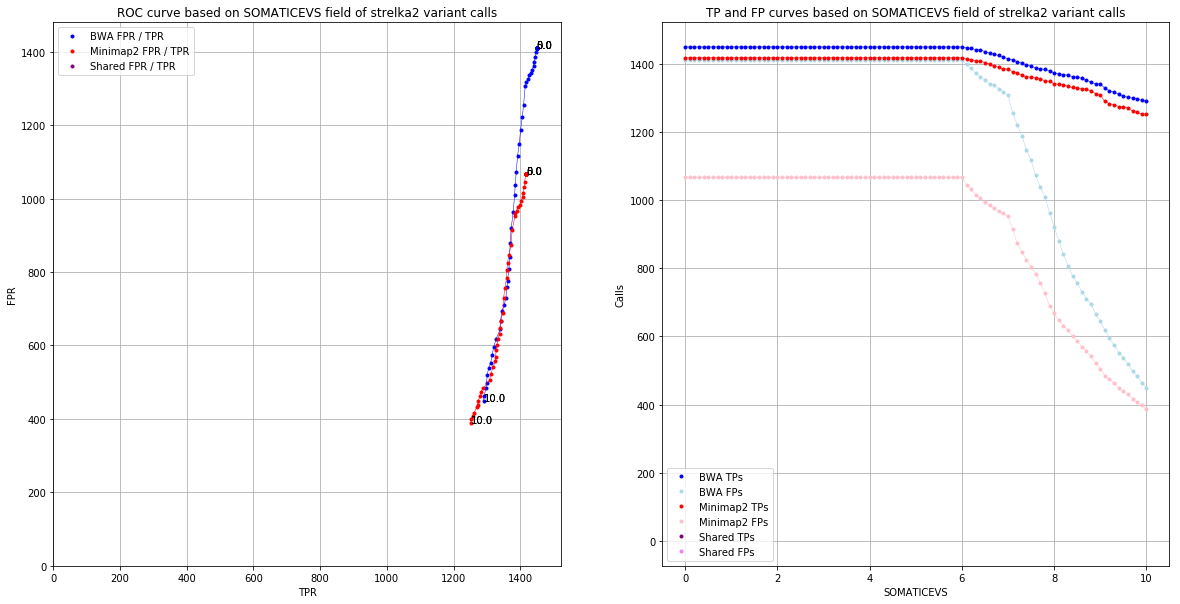

In [59]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'SomaticEVS', 0, 10, 0.1)
pass

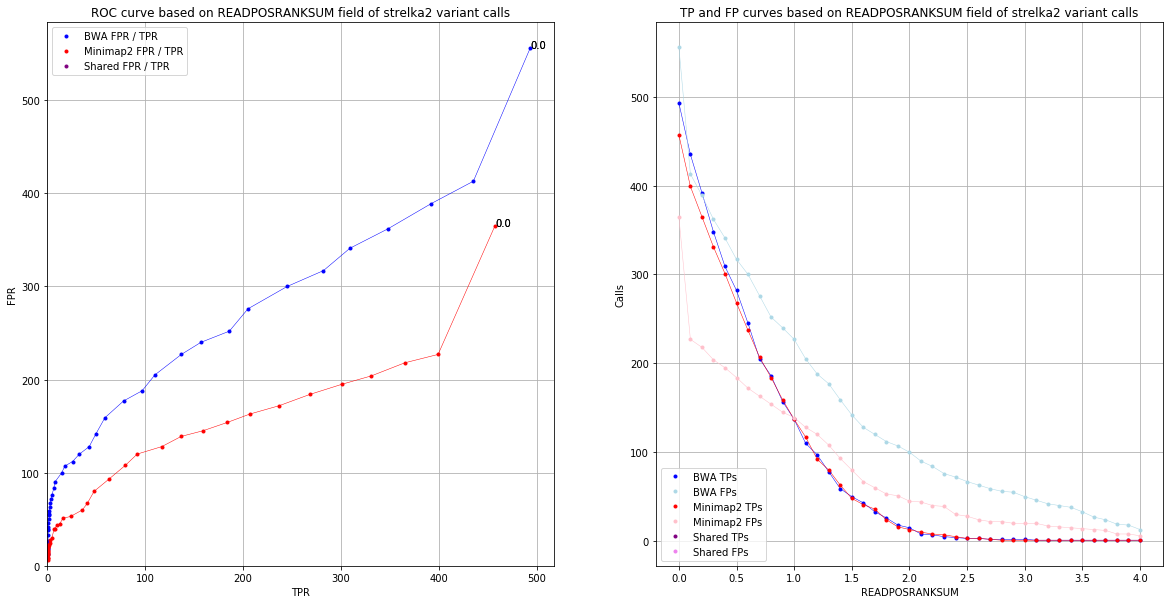

In [63]:
# Strelka2 SomaticEVS ROC curve
plot_roc('strelka2', 'ReadPosRankSum', 0, 4, 0.1)
pass

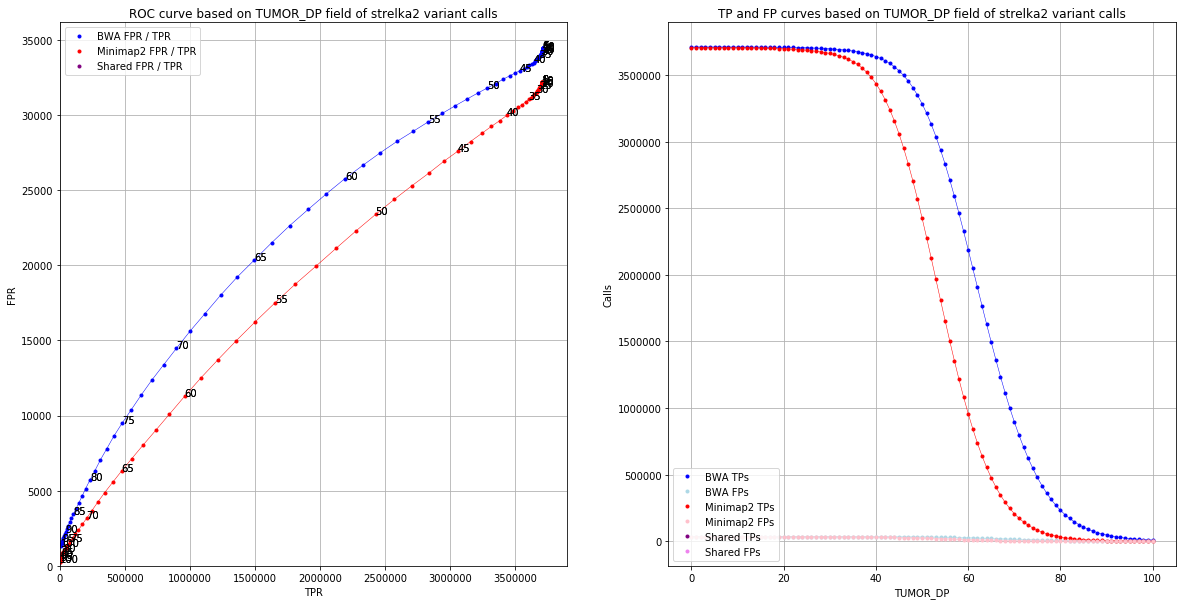

In [6]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'TUMOR_DP', 0, 100, 1)
pass

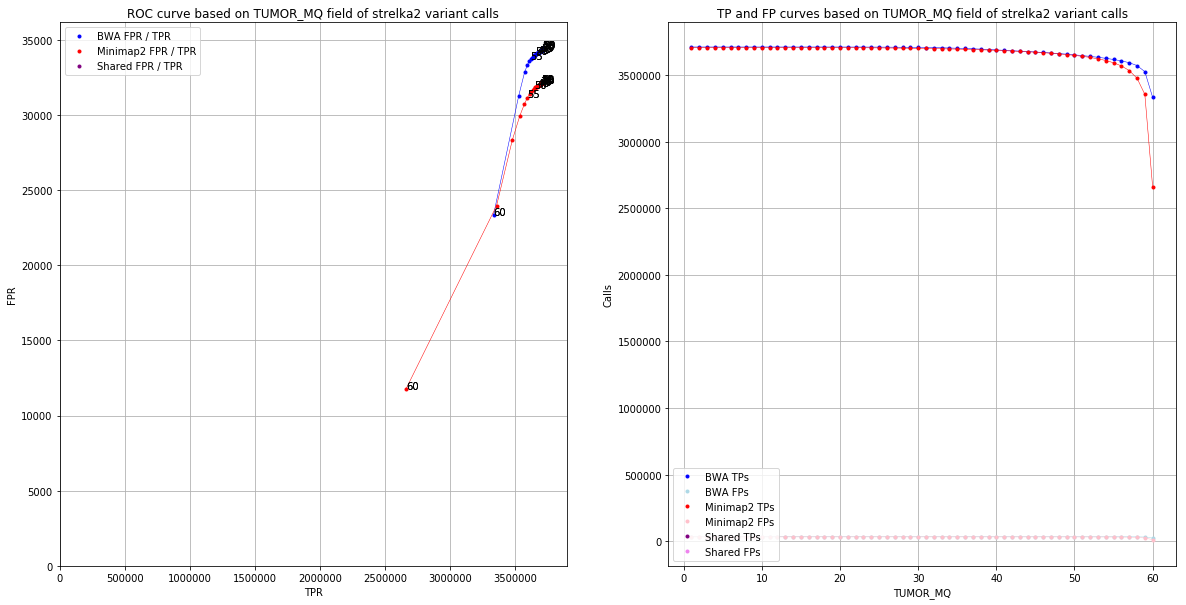

In [7]:
# Strelka2 DP ROC curve
plot_roc('strelka2', 'TUMOR_MQ', 1, 60, 1)
pass
# Annotate dots with gene names:
# for _, r in df[df[f'bwa_mq'] < 20][df[f'bwa_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'bwa_mq']))
# for _, r in df[df[f'mm2_mq'] < 20][df[f'mm2_mq'] > 0].iterrows():
#     ax.annotate(r['pos'], xy=(r['x'], r[f'mm2_mq']))

# Observations:
# - Chromosome 8: many bwa and minimap FP, but only few are shared.
# 
# TODO: 
# - ROC and other validatiopn stats based on MQ
# - Figure out high depth regions

*Plotting variants with X axis as a genome position, and Y axis as a feature (MQ, DP, etc).*
- red dot represent a variant called with minimap2
- blue dot represent a variant called wit BWA
- variants called with both aligners are connected with vertical lines
- pale colors represent false positives, bright colors correspond to true positives
- green dots at the bottom represent shared false negatives (i.e. true variants not called with any aligner)
- those that overlap with low complexity or high/low tricky regions, scatterred with x; others scatterred with .

In [22]:
from ngs_utils.call_process import run

def subset_unique(caller, aligner):
    strelka = df[df['caller'] == caller]
    uniq_tp = strelka[strelka['category'] == f'unique_tp_{aligner}']
    lbls = uniq_tp['label'].tolist()

    inp_vcf = VCF(vcfs[caller][aligner]['tp'])
    out_path = f'{caller}_uniq_to_{aligner}_tp.vcf'
    with open(out_path, 'w') as vcf_f, open(out_path + '.bed', 'w') as bed_f:
        vcf_f.write(inp_vcf.raw_header)
        for rec in inp_vcf:
            lbl = f'{rec.CHROM}:{rec.POS}-{rec.REF}>{rec.ALT[0]}'
            if lbl in lbls:
                vcf_f.write(str(rec))
                bed_f.write(f'{rec.CHROM}\t{rec.POS-100}\t{rec.POS+100}\n')
    return out_path

In [23]:
#vcf_bwa = subset_unique('strelka2', 'bwa')

In [24]:
#vcf_mm2 = subset_unique('strelka2', 'mm2')

In [25]:
def subset_bam(beds, caller):
    beds = ' '.join(beds)
    run(f'cat {beds}' +
        f' | bedtools sort -i stdin' +
        f' | bedtools merge -i stdin' +
        f' > {caller}_unique.bed'
    )

#subset_bam([vcf_bwa + '.bed', vcf_mm2 + '.bed'], 'strelka2')

cat strelka2_uniq_to_bwa_tp.vcf.bed strelka2_uniq_to_mm2_tp.vcf.bed | bedtools sort -i stdin | bedtools merge -i stdin > strelka2_unique.bed
